In [ ]:
#@title Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import sparse
import os.path
from os import path
import pickle

In [ ]:
# if your data is not in Colab, click on 'mount Drive' under Files on the left

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#@title Functions
# set up functions

def loading_data(date,variable_name):
  '''
  Loading function for .npy files that can be used. 
  Most functions are loading the variables themselves already though.

  input:  date (day as a 2 digit string), 
          variable name (string), '.npy' is added automatically
  output: loaded file (assign to variable name)
  '''
  path = 'drive/My Drive/NMA/Lederberg_2017-12-' + date + '/'
  output = np.load(path + variable_name + '.npy')
  return output 


def x_to_states(feedback):
  '''
  function to feedback (-1 = punishment, 1 = reward) into binary states (0, 1).
  Then looks at subsequent trials and their reward combinations.
  # 0 = 2 subsequent punishments 00
  # 1 = punishment then reward 01
  # 2 = reward then punishment 10
  # 3 = 2 subsequent rewards 11

  NOT TAKING INTO ACCOUNT THE EXCLUSION CRITERIA (DISENGAGEMENT) FOR EACH TRIAL

  input:  feedback array, size: [nTrials,]
  output: conversion_matrix_binary size: [nTrials,]
  '''
  # change all -1 to 0 
  for i in range(0, len(feedback)):
    if feedback[i] == -1: 
      feedback[i] = 0

  # conversion to states
  conversion_matrix = np.zeros((len(feedback)+1, 2)) #create an array of zeroes with rows = length of feedback+1 and columns = 2
  conversion_matrix[0:len(feedback),0] = feedback[:,0] #add feedback in the first column 
  conversion_matrix[1:len(feedback)+1,1] = feedback[:,0] #add feedback in the second column shifted 1 row down
  conversion_matrix = conversion_matrix[1:-1] #remove first and last rows

  conversion_matrix_binary = conversion_matrix[:,0]*2 + conversion_matrix[:,1] # convert to a binary matrix 
  # 0 = 2 subsequent punishments 00
  # 1 = punishment then reward 01
  # 2 = reward then punishment 10
  # 3 = 2 subsequent rewards 11

  return conversion_matrix_binary

def get_cells2keep(drivepath):
  '''
  Finds only the good and useable clusters. Loads _phy_annotation to do so.

  input:  drivepath (file location)
  output: cells2keep: boolean array (size: [ncluster,]): 1 keep, 0 toss
  '''
  phyLabel = np.load(drivepath + 'clusters._phy_annotation.npy') # 0: excluded/noise    1: excluded because MUA   2: good    3: unsorted
  
  cells2keep = phyLabel >= 2 # take only cells with good labels 
  cells2keep = np.squeeze(cells2keep) # boolean array: 1 keep, 0 toss
  return cells2keep

def get_brain_area(cells2keep,drivepath):
  '''
  Finds brain areas for the good and useable clusters.
  Loads the brainLocation.tsv for every channel and finding the most likely  
  channel for every cluster. 

  input:  cells2keep (from function get_cells2keep)
            boolean array. size: [ncluster,]): 1 keep, 0 toss
          drivepath (file location)
  output: loc2keep Brain location acronym (Allen Brain based). 
            ndarray of size: [ngoodCluster,]
          brain_area_indx. same size as loc2keep. us to index 
            brain_regions (from get_brain_area_list)
  '''
  # load needed files
  chanLocs = pd.read_csv(drivepath + "channels.brainLocation.tsv",sep='\t') # get channel locations 
  peakChan = np.load(drivepath + 'clusters.peakChannel.npy') # find corresponding channel for each cluster

  # process / index
  chanLocs = chanLocs['allen_ontology']
  peakChan = np.squeeze(peakChan)
  cellLoc = chanLocs[peakChan]
  cellLoc = cellLoc.to_numpy()
  loc2keep = cellLoc[cells2keep]

  ###
  brain_regions, brain_areas = create_brain_area_list()
  brain_area_indx = np.zeros(loc2keep.shape)

  for id in range(len(brain_area_indx)):
    area_idx = np.zeros((len(brain_areas)))
    for area in range(len(brain_areas)):
      area_idx[area] = np.isin(loc2keep[id], brain_areas[area])
    brain_area_indx[id] = area_idx.argmax()

  return loc2keep, brain_area_indx


def create_spike_matrix(cells2keep,drivepath):
  '''
  For every good cluster, loads & grabs all the spike times and puts it in a list.

  input:  cells2keep (from function get_cells2keep)
            boolean array. size: [ncluster,]): 1 keep, 0 toss
          drivepath (file location)
  output: spike_matrix (in seconds). list of size: [ngoodCluster,] 
            with each row being an array of the spike times
  '''
  #load data
  spike_cluster = np.load(drivepath+'spikes.clusters.npy')
  spike_times = np.load(drivepath+'spikes.times.npy')
  
  num_clusters = len(np.unique(spike_cluster))

  # convert data in array: every row is putative neuron, with all its spike times
  spike_matrix = [] # make list
  cnt=-1
  for ncluster in range(0,num_clusters,1):
    if cells2keep[ncluster]: # only select the good clusters
      cnt +=1
      arr = np.asarray(spike_times[spike_cluster==ncluster])
      spike_matrix.append([]) 
      
      for j in range(len(arr)):  # append
        spike_matrix[cnt].append(arr[j]) 
  
  return spike_matrix


def create_time_binned_spike_matrix(spike_matrix, binSize):
  '''
  Turns spike time matrix into boolean array with 1 = spike, 0 = no spike.

  input:  spike_matrix (from function create_spike_matrix)
            spike times for each cluster. list size: [ncluster, *varying array length*])
  output: spike_matrix . boolean array of size: [ngoodCluster, n_timebins]
            one column = one millisecond
            1 = spike, 0 = no spike.
          
  '''
  mx = np.max(np.max(spike_matrix))
  num_bins = int(np.ceil(mx*(1/binSize))) # last time point (in ms)

  spikes_binned_ms = np.zeros((int(len(spike_matrix)),num_bins),dtype=bool) # initialize array
  for i in range(0,len(spike_matrix),1):
    data = np.multiply(spike_matrix[i],1/binSize) # turn spike times from s into ms
    histcount, _ = np.histogram(data,bins = np.linspace(0,num_bins,num_bins+1)) # histogram for each occuring spike
    spikes_binned_ms[i,:] = np.array(histcount,dtype=bool)

  return spikes_binned_ms
  

def save_sparse(spikes_binned_ms, drivepath):
  '''
  Turns the time binned (ms) spike matrix into sparse matrix and save it. Saves memory.

  input: spikes_binnes_ms, boolean, size: [ngoodcluster,timebins(ms)]
         drivepath (file location)
  output: the saved file <spikes_sparse>, same size as input array
  '''
  spikes_sparse = sparse.csr_matrix(spikes_binned_ms)
  scipy.sparse.save_npz(drivepath+'spikes_binned_ms_sparse.npz', spikes_sparse)
  return spikes_sparse


def load_all_timestamps_of_trials(drivepath):
  '''
  Simply loads all the time_stamped arrays from all trials in the order they occur relative to each other.
  each array is of size [nTrials,]

  Input: drivepath (file location)
  Output: trial_times, vis_stim, goCue, resp_times, feedback_times
  '''
  trial_times = np.load(drivepath+'trials.intervals.npy') # in seconds. stim starts after wheel was still for 1.5 s
  vis_stim = np.load(drivepath+'trials.visualStim_times.npy')
  goCue = np.load(drivepath+'trials.goCue_times.npy') # in seconds, this is after seeing the stimulus. now the mouse can move the wheel which is now coupled ot the stim location
  resp_times = np.load(drivepath+'trials.response_times.npy')
  feedback_times = np.load(drivepath+'trials.feedback_times.npy') # is shortly before end of interval (trial_times[:,1])
  
  # During the 1 s feedback period, the visual stimulus remained on the screen. After a subsequent inter-trial interval of 1 s, [...from paper]
  return trial_times, vis_stim, goCue, resp_times, feedback_times


def getHistTrials(spike_matrix_binned_sparse, binSize, trial_times, trials_idx, stim_time, brain_area_indx, brain_area_of_interest_indx):
  """ a function that transforms a sparse matrix into separate histograms for resting and task performance periods
  args:           spike_matrix_binned_sparse - sparse logical matrix with all cells
                  binSize                         - time bin size = bins per second (1000 corresponds to ms)
                  trial_times                     - 2D numpy array with trial start, trial stop
                  trials_idx                      - indices of trials of interest
                  stim_time                       - stimulation time, has to be same length as trial_times
                  brain_area_indx                 - an integer array with brain location idx of each unit
                  brain_area_of_interest_indx     - integer array with areas of interest

  output:         trialsHist                 - n_trial X 4 dictionary with keys: 1) histogram of rest period
                                                                                 2) time stamps of rest period
                                                                                 3) histogram of task period
                                                                                 3) time stamps of task period
  """
  trialsHist  = {} # set up the dictionary
  fullMat     = spike_matrix_binned_sparse.toarray()
  time        = np.linspace(0, np.shape(fullMat)[1]*binSize, np.shape(fullMat)[1])
  trials2keep = trial_times[trials_idx,:]
  stim2keep   = stim_time[trials_idx]
  cells2keep = brain_area_indx == brain_area_of_interest_indx
  # cells2keep  = np.isin(brain_area_indx, brain_area_of_interest) 
  # brain_area_indx==brain_area_of_interest # gives only 1 boolean value, and we need to index all neurons (and keep ones that are in that brain region)   
  #np.isin(brain_loc, areas) # old notation
  
  print('# cells that are in brain area:', np.sum(cells2keep))
  
  if(np.sum(cells2keep) == 0):
    # raise exception('this brain area was not recorded, ask for another pls')
    print('this brain area was not recorded and is skipped')
  else:  
    for triali in range(np.shape(trials2keep)[0]):  
      start   = np.argmin(np.abs(time - trials2keep[triali,0]))
      stop    = np.argmin(np.abs(time - trials2keep[triali,1]))
      stim    = np.argmin(np.abs(time - stim2keep[triali]))
      parMatRest  = fullMat[cells2keep,start:stim]
      parMatTask  = fullMat[cells2keep,stim:stop]
      timevecRest = np.linspace(trials2keep[triali,0],stim2keep[triali], np.shape(parMatRest)[1] )
      timevecTask = np.linspace(stim2keep[triali], trials2keep[triali,1], np.shape(parMatTask)[1] )

      #save into a dictionary
      trialsHist[triali,0] = parMatRest
      trialsHist[triali,1] = parMatTask
      trialsHist[triali,2] = timevecRest
      trialsHist[triali,3] = timevecTask 

    # print(triali)
    return trialsHist


def create_brain_area_list():
  # groupings of brain regions
  brain_regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
  brain_areas = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

  return brain_regions, brain_areas

def get_trial_times(trial_times, vis_stim, feedback_times, bin_size):
  # get timestamps of events for task and waiting period  
  
  waiting_period = np.vstack((np.squeeze(trial_times[:,0]),np.squeeze(vis_stim))).T # this is probably ugly, complicated rearranging of arrays, but it works so.. possibly put into a function?
  task_period = np.vstack((np.squeeze(vis_stim),np.squeeze(feedback_times))).T
  
  # I hope taking the floor is ok? yup
  waiting_period_ms = np.floor(waiting_period*1/bin_size) # times in ms = bins in spike_matrix
  task_period_ms =  np.floor(task_period*1/bin_size)

  return waiting_period_ms, task_period_ms


def get_crossvalidation(total_samples, input_seed = 27):
  # pick the train, validation and test set
  # returns data split idx   
  # random seed fixed, if needed use 2nd argument

  np.random.seed(input_seed)

  samples_idx = np.arange(0,total_samples)

  test_no = int(np.ceil(0.1 * total_samples))
  val_no = int(np.ceil(0.2 * total_samples))
  train_no = total_samples - (test_no + val_no) # implicit

  idx_train = np.random.choice(samples_idx, train_no, replace=False)
  idx_val = np.random.choice(np.setdiff1d(samples_idx,idx_train), val_no, replace=False)
  idx_test = np.setdiff1d(samples_idx, np.concatenate((idx_train, idx_val)))

  return idx_train, idx_val, idx_test

# trials idx by contrast: 0 for max contrast (get rid of it?), 1 for equal contrast (random reward), 2 for everything else (trials we want to keep) 
def matrix_F_L_R(date): 
  tmp_feedback = loading_data(date,'trials.feedbackType') # load the feedback file corresponding to chosen date
  tmp_contrast_left = loading_data(date,'trials.visualStim_contrastLeft') # load the contrast left file corresponding to chosen date
  tmp_contrast_right = loading_data(date,'trials.visualStim_contrastRight') # load the contrast right file corresponding to chosen date
  # previously:
  # tmp_feedback = loading_data(date,variable_feedback) # load the feedback file corresponding to chosen date
  # tmp_contrast_left = loading_data(date,variable_contrastL) # load the contrast left file corresponding to chosen date
  # tmp_contrast_right = loading_data(date,variable_contrastR) # load the contrast right file corresponding to chosen date
  
  array = np.zeros((len(tmp_feedback), 4)) #create all zeroes array with row = length of feedback (= length of contrastL&R) and columns = 3
  array[0:len(tmp_feedback),1] = tmp_feedback[:,0] # add feedback to the first column
  array[0:len(tmp_feedback),2] = tmp_contrast_left[:,0] #add contrast left to the second column
  array[0:len(tmp_feedback),3] = tmp_contrast_right[:,0] # add contrast right to the third column

  for i in range(0, len(tmp_feedback)):
    if tmp_contrast_left[i,0] == 1 or tmp_contrast_right[i,0] == 1:
      array[i,0] = 0
    elif tmp_contrast_left[i,0] == tmp_contrast_right[i,0]:
      array[i,0] = 1
    else:
      array[i,0] = 2

  return array

# where there's a 0 in the first column 
def select_low_contrast_trials(date):
  array = matrix_F_L_R(date)
  
  array_low_contrast = array[array[:,0]>1,:]

  return array_low_contrast

def save_obj(spikes_dict_all, save_name):
    with open(save_name + '.pkl', 'wb') as f:
        pickle.dump(spikes_dict_all, f, pickle.HIGHEST_PROTOCOL)


In [ ]:
def concatenate_trials(input_dict, pick): 
 # functions to concatenate trials if the input is dictionary
 # expected input is of shape like output of getHistTrials

  out = {} # init dictionary 
  no_neurons = np.shape(input_dict[0,pick])[0]
  out[0,pick] = input_dict[0,pick] # first trial
  for trials in np.arange(1, no_neurons):
    out[0,pick] = np.concatenate([out[0,pick], input_dict[trials,pick]], axis = 1) # concatenating 

  return out

concatenate_trials(spikes_dict_training, 0)


KeyError: ignored

In [ ]:
# grabbing/loading the data and preprocessing:
dates = ['05', '06', '07', '08', '09', '10', '11']
bin_size = 0.001 # 1 ms

# specify brain area of interest
brain_area_of_interest_indx = 0 # order: ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_regions, _ = create_brain_area_list()

# concatenate sessions for training (iterate over crossvalidation idx)
for idx_session in range(len(dates)): # idx_train: 
  print('Session no: ', idx_session)

  # select folder for this session
  date = dates[idx_session] # change to iterator later
  drivepath = 'drive/My Drive/NMA/Lederberg_2017-12-' + date + '/'

  # load the session data and get task and waiting period times
  trial_times, vis_stim, goCue, resp_times, feedback_times = load_all_timestamps_of_trials(drivepath)
  waiting_period_ms, task_period_ms = get_trial_times(trial_times, vis_stim, feedback_times, bin_size)
  feedback = loading_data(date, 'trials.feedbackType')
  stim_time = loading_data(date, 'trials.visualStim_times')
  # plt.hist(np.diff(waiting_period_ms)) # check how long does the waiting period last

  # contrast IDs
  contrast_trials = matrix_F_L_R(date)

  # check which cluster are worth analyzing (2+ score on Kilosort)
  print('get good clusters...')
  cells2keep = get_cells2keep(drivepath)

  # connect clusters to brain areas 
  print('get brain areas...')
  loc2keep, brain_area_idx = get_brain_area(cells2keep, drivepath)

  if not path.isfile(drivepath+'spikes_binned_ms_sparse.npz'): # hasn't been created yet

    # transform into spike matrix and bin it
    print('grabbing spike times...')
    spike_matrix = create_spike_matrix(cells2keep, drivepath)
    spikes_binned_ms = create_time_binned_spike_matrix(spike_matrix, bin_size)  

    # # iterate over neurons to see if there is any empty rows
    # threshold = 0
    # for neuron_ID in len(spikes_binned_ms):
    #   tmp_trial = np.mean(spikes_binned_ms[neuron_ID])
    #   if tmp_trial <= threshold  
    #     # delete that trial
    #     np.delete(spikes_binned_ms[neuron_ID])
    # other variables also need to be moved around

    # turn into a sparse format and save
    print('sparsifying and saving spike_matrix_binned...')  
    spike_matrix_binned_sparse = save_sparse(spikes_binned_ms, drivepath)

  else:
    print('found pre-computed sparse spiking matrix. loading...')
    spike_matrix_binned_sparse = scipy.sparse.load_npz(drivepath+'spikes_binned_ms_sparse.npz')
    # if need dense matrix
    spikes_binned_ms = spike_matrix_binned_sparse.todense()

  # n_trial X 4 dictionary with keys: 1) histogram of rest period (Boolean spikes)
  #                                   2) time stamps of rest period
  #                                   3) histogram of task period (Boolean spikes)
  #                                   4) time stamps of task period

  if not path.isfile(drivepath+ 'train_val_test_' + brain_regions[brain_area_of_interest_indx] + '.npz'): # hasn't been created yet
    # get crossvalidation index for each session
    print('get crossvalidation indices')
    idx_train, idx_val, idx_test = get_crossvalidation(len(contrast_trials))

    print('extract trials')
    # trials_idx = range(0, len(trial_times)) # all trials
    spikes_dict_training = getHistTrials(spike_matrix_binned_sparse, bin_size, trial_times, idx_train, stim_time, brain_area_idx, brain_area_of_interest_indx)
    spikes_dict_val = getHistTrials(spike_matrix_binned_sparse, bin_size, trial_times, idx_val, stim_time, brain_area_idx, brain_area_of_interest_indx)
    spikes_dict_test = getHistTrials(spike_matrix_binned_sparse, bin_size, trial_times, idx_test, stim_time, brain_area_idx, brain_area_of_interest_indx)

    train_matrix = {'spikes': spikes_dict_training, 'brain_region': brain_area_idx[idx_train], 'contrast_ID': contrast_trials[idx_train], 'feedback': feedback[idx_train], 'feedback_times': feedback_times[idx_train]}
    val_matrix = {'spikes': spikes_dict_val, 'brain_region': brain_area_idx[idx_val], 'contrast_ID': contrast_trials[idx_val], 'feedback': feedback[idx_val], 'feedback_times': feedback_times[idx_val]}
    test_matrix = {'spikes': spikes_dict_test, 'brain_region': brain_area_idx[idx_test], 'contrast_ID': contrast_trials[idx_test], 'feedback': feedback[idx_test], 'feedback_times': feedback_times[idx_test]}

    print('save tr-val-test matrix')
    np.savez(drivepath + 'train_val_test_' + brain_regions[brain_area_of_interest_indx], '_', \
          name1 = train_matrix, name2 = val_matrix, name3 = test_matrix, \
          name4 = idx_train, name5 = idx_val, name6 = idx_test)
  else:
    print('found the train_val_test file for this session and brain area already and won"t recompute')
# # # end of preprocessing # # #

print('DONE!!!')

Session no:  0
get good clusters...
get brain areas...
found pre-computed sparse spiking matrix. loading...
get crossvalidation indices
extract trials
# cells that are in brain area: 245
# cells that are in brain area: 245
# cells that are in brain area: 245
save tr-val-test matrix
Session no:  1
get good clusters...
get brain areas...
grabbing spike times...


FileNotFoundError: ignored

In [ ]:
whos


Interactive namespace is empty.


In [ ]:
# LOAD data again

drivepath = 'drive/My Drive/NMA/Lederberg_2017-12-' + '05' + '/'

dataset = np.load(drivepath+'train_val_test_vis ctx.npz', allow_pickle=True)
# lst = dataset.files
# lst
# name1 = train_matrix, name2 = val_matrix, name3 = test_matrix, \
# name4 = idx_train, name5 = idx_val, name6 = idx_test)
train_matrix = dataset['name1'][()] # train_matrix
val_matrix = dataset['name2'][()]
test_matrix = dataset['name3'][()]
train_matrix.keys()

In [ ]:
def concatenate_trials(input_dict, pick): 
 # functions to concatenate trials if the input is dictionary
 # expected input is of shape like output of getHistTrials

  out = {} # init dictionary 
  keys = np.array(list(spikes.keys()))
  no_trials, _ = np.shape(keys) 
  no_neurons = np.shape(input_dict[0,pick])[0]
  out[0,pick] = input_dict[0,pick] # first trial
  for trials in np.arange(1, int(no_trials/4)):
    out[0,pick] = np.concatenate([out[0,pick], input_dict[trials,pick]], axis = 1) # concatenating 

  return out



220


In [ ]:
spikes = train_matrix['spikes']
np.shape(spikes[0,0])
waiting_period = concatenate_trials(spikes, 0)
np.shape(out[0,0]) # shape: n_Neurons x (trials x time)

In [ ]:
# write a check trial-wise and for waiting vs resting

threshold = 0.1 # Hz
count = 0
tmp_neurons = np.zeros((len(spikes_binned_ms),1))
for neuron_ID in range(len(spikes_binned_ms)):
  tmp_neurons[neuron_ID] = np.mean(spikes_binned_ms[neuron_ID])/bin_size
  if (tmp_neurons[neuron_ID] < threshold):
    count = count+1
print('# neurons with less than 0.1 Hz activity:',count)

# spikes3d
# np.hstack(spikes3d[k] for k in spikes3d
# print(spikes3d.values())
# np.concatenate(spikes3d.values(), axis= 1)
# %whos

# neurons with less than 0.1 Hz activity: 37


Text(0, 0.5, 'neurons')

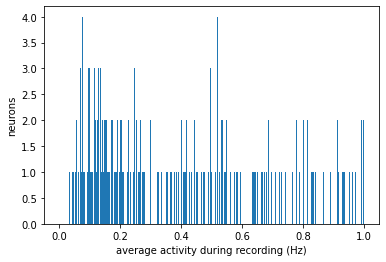

In [ ]:
h = plt.hist(tmp_neurons, bins=500, range=(0, 1))
plt.xlabel('average activity during recording (Hz)')
plt.ylabel('neurons')

In [ ]:
# add shuffled task period to spikes_dict
rand_indx = np.random.permutation(trials_idx)
spikes_dict2 = spikes_dict
# spikes_dict
for trial_i in range(len(trials_idx)):
  spikes_dict2[trial_i,5] = spikes_dict2[rand_indx,1]

In [ ]:
# neurons x trials, where trials contain spike times and time vector
# train_matrix = [] # outisde the sessions loop
# train_matrix = np.hstack(train_matrix, spikes_binned_ms) 
# code to delete some trials: optional

# spikes_dict = getHistTrials(spike_matrix_binned_sparse, bin_size, trial_times, trials_idx, stim_time, brain_area_idx, brain_area_of_interest_indx=2)
# TIME VECTORS ARE EMPTY
tmp_task = spikes_dict[0,1]
#print(np.sum(tmp_task[201,:]==True))
#tmp_task = spikes_dict[1,3]
#print(tmp_task)

# np.save(save_name, spikes_dict_all)

# fill in aditional details
train_matrix = {'Spikes': spikes_dict_all, 'brain_region', brain_area_idx, 'contrast_ID', contrast_trials, 'feedback', feedback()}
# session ID
# brain region
# trial ID (Hiba's code)
# validation status (0 - training, 1 - validation, 2 - test)

10


In [ ]:
brain_area

'cortex'

In [ ]:
print(spikes_dict[1,0].shape)

(0, 688)


In [ ]:
spikes_dict_all = {'Spikes': spikes_dict, 'session_ID': idx_session, 'brain_region': brain_area_idx, 'contrast_ID': contrast_trials}
# print(spikes_dict_all)
print(spikes_dict_all.keys())
save_name = drivepath + 'processed/spikes_dict_s' + str(idx_session) # + '.npy'
save_obj(spikes_dict_all, save_name)

dict_keys(['Spikes', 'session_ID', 'brain_region', 'contrast_ID'])


In [ ]:
# # previous code  
# if not path.isfile(drivepath+'spikes_binned_ms_sparse.npz'): # hasn't been created yet
#   print('grabbing spike times...')
#   spike_matrix = create_spike_matrix(cells2keep),drivepath # spike times for each good cluster
#   print('binning spike times...')
#   spike_matrix_binned = create_time_binned_spike_matrix(spike_matrix) # boolean array in ms for each cluster = row
#   print('sparsifying and saving spike_matrix_binned...')
#   # save_sparse(spike_matrix_binned,drivepath)    # sparsify for storage/memory reason
#   spike_matrix_binned_sparse = save_sparse(spike_matrix_binned,drivepath) # sparsify for storage/memory reason
# else:
#   print('found pre-computed sparse spiking matrix. loading...')
#   spike_matrix_binned_sparse = scipy.sparse.load_npz(drivepath+'spikes_binned_ms_sparse.npz')
#   # if need dense matrix
#   # spike_matrix_binned = scipy.sparse.ourBelovedSparseMatrix.todense(spike_matrix_binned_sparse)

# trial_times, vis_stim, goCue, resp_times, feedback_times = load_all_timestamps_of_trials(drivepath)
# # possibly put the following few lines into a function?
# waiting_period = np.vstack((np.squeeze(trial_times[:,0]),np.squeeze(vis_stim))).T # this is probably ugly, complicated rearranging of arrays, but it works so.. possibly put into a function?
# task_period = np.vstack((np.squeeze(vis_stim),np.squeeze(feedback_times))).T
# # I hope taking the floor is ok? yup
# waiting_period_ms = np.floor(waiting_period*1/binSize) # times in ms = bins in spike_matrix
# task_period_ms =  np.floor(task_period*1/binSize)

# # grab the spike_matrix elements for each desired trial

# # need to specify trials_idx
# trials_idx = np.linspace(0,len(trial_times),1)
# # brain area of interest can be an integer between 0 and 7
# trialsHist = getHistTrials(spike_matrix_binned_sparse, binSize, trial_times, trials_idx, vis_stim, brain_area_indx, brain_area_of_interest=0)


In [ ]:
%whos

Variable                          Type          Data/Info
---------------------------------------------------------
bin_size                          float         0.001
brain_area                        str           cortex
brain_area_idx                    ndarray       698: 698 elems, type `float64`, 5584 bytes
cells2keep                        ndarray       1219: 1219 elems, type `bool`, 1219 bytes
contrast_trials                   ndarray       340x4: 1360 elems, type `float64`, 10880 bytes
count                             int           37
create_brain_area_list            function      <function create_brain_ar<...>a_list at 0x7f6b23657e18>
create_spike_matrix               function      <function create_spike_matrix at 0x7f6b253af730>
create_time_binned_spike_matrix   function      <function create_time_bin<...>matrix at 0x7f6b253af2f0>
date                              str           05
dates                             list          n=1
drive                             module

# timing sequence:

START of trial: trial_times[:,0],     
WAITING  (what happens here??)     
vis_stim,     
(random delay)
goCue,    
resp_times,  
very quickly: feedback_times,     
END of trial: trial_times[:,1]

so we care only about:

trial start - vis_stim  = **waiting period**

vis_stim - feedback     = **task period**

SyntaxError: ignored